# Capstone Project

### Import libraries and modules

In [66]:
# Import libraries and modules for numerical operations and data manipulation
import numpy as np
import pandas as pd
from random import sample

# Import libraries and modules for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from wordcloud import WordCloud

# Import NLP module for text processing
import spacy

# Import modules and functions for modeling
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Binarizer, binarize
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, roc_auc_score, make_scorer
from sklearn import metrics

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import KMeansSMOTE

# Import other modules
import re
import warnings
sns.set_style("whitegrid")

### Read and inspect data
- Read the data.
- Perform some basic structural cleaning.
- Review the class distribution in the dataset.

In [45]:
# Import and load dataset
excel = '/Users/stephanienduaguba/Documents/DSI Files/Capstone Project/EarningsCalls_data_2007-2021.xlsx'
df = pd.read_excel(excel)

# Drop the 'Unnamed' and 'filename' columns
df.drop(['Unnamed: 0', 'filename'], axis=1, inplace=True)

# Rename the 'Label' column to 'label'
df.rename(columns={'Label': 'label'}, inplace=True)

# Display a random sample of 5 rows
df.sample(n=5, random_state=42)

,title,text,label
753,"Itron, Inc. (ITRI) Q1 2009 Earnings Call Trans...",Steve Sanders – Stephens Inc. John Quealy – ...,0
519,"The Williams Companies, Inc. (NYSE:WMB) 2020 W...","Praneeth Satish Okay, good afternoon. And th...",1
210,Ashford Hospitality Trust (NYSE:AHT) Q4 2007 E...,Harry Sullivan – Senior Vice President and Pr...,0
943,Comfort Systems USA Q4 2007 Earnings Call Febr...,"Matt Duncan – Stephens, Inc David Yuschak - ...",0
915,PHH Corp. (NYSE:PHH) Q4 2007 Earnings Call Feb...,Jordan Hymowitz - Philadelphia Financial Gab...,1


In [46]:
# Dictionary mapping numerical labels to text labels
label_to_sentiment = {0: "Non-Bankrupt", 1: "Bankrupt"}

# Function that decodes numerical labels to text
def label_decoder(label):
    # Return the corresponding text label for a given numerical label
    return label_to_sentiment[label]

# Apply the label_decoder function to each element in the 'label' column
# Store the results in a new 'sentiment' column in the DataFrame
df['sentiment'] = df['label'].apply(lambda x: label_decoder(x))

# Display a random sample of 5 rows
df.sample(n=5, random_state=42)

,title,text,label,sentiment
753,"Itron, Inc. (ITRI) Q1 2009 Earnings Call Trans...",Steve Sanders – Stephens Inc. John Quealy – ...,0,Non-Bankrupt
519,"The Williams Companies, Inc. (NYSE:WMB) 2020 W...","Praneeth Satish Okay, good afternoon. And th...",1,Bankrupt
210,Ashford Hospitality Trust (NYSE:AHT) Q4 2007 E...,Harry Sullivan – Senior Vice President and Pr...,0,Non-Bankrupt
943,Comfort Systems USA Q4 2007 Earnings Call Febr...,"Matt Duncan – Stephens, Inc David Yuschak - ...",0,Non-Bankrupt
915,PHH Corp. (NYSE:PHH) Q4 2007 Earnings Call Feb...,Jordan Hymowitz - Philadelphia Financial Gab...,1,Bankrupt


In [47]:
# Display the number of rows and columns
df.shape

(1016, 4)

In [48]:
# Display the data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      1016 non-null   object
 1   text       1016 non-null   object
 2   label      1016 non-null   int64 
 3   sentiment  1016 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.9+ KB


In [49]:
# Count of each unique value in the 'sentiment' column
sentiment_counts = df['sentiment'].value_counts()

# Percentage of each unique value in the 'sentiment' column
sentiment_percentages = df['sentiment'].value_counts(normalize=True) * 100

# Combine the counts and percentages into one DataFrame for a comprehensive view
sentiment_summary = pd.DataFrame({
    'Counts': sentiment_counts,
    'Percentage': sentiment_percentages
})

# Display the result
print(sentiment_summary)

              Counts  Percentage
sentiment                       
Non-Bankrupt     705   69.389764
Bankrupt         311   30.610236


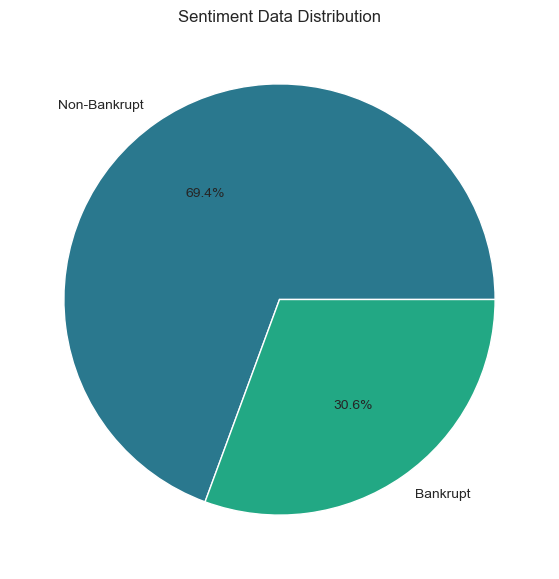

In [50]:
# Sentiment data distribution plot
# Calculate counts of each sentiment
sentiment_counts = df['sentiment'].value_counts()

# Define custom colors for the pie chart
colors = ['#2A788EFF','#22A884FF']

# Create a pie chart
plt.figure(figsize=(14, 7))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=colors)

# Add a title
plt.title("Sentiment Data Distribution")

# Display the pie chart
plt.show()

*The dataset comprises transcripts from earnings calls of various companies, sourced from the Seeking Alpha website. Initial analysis reveals that the dataset is skewed, predominantly featuring transcripts from non-bankrupt firms, a common characteristic for datasets of this nature. The data is complete, with no missing entries noted. However, it requires some text preprocessing to be suitable for analysis through an NLP (Natural Language Processing) pipeline. The subsequent section outlines the preliminary preprocessing steps undertaken on the dataset before its introduction into the NLP workflow.*

### Preprocess text
- Lowercase: Convert all characters in the text to lowercase to ensure uniformity.
- Remove URLs: Find and remove all URLs. This applies to URLs starting with http://, https://, and www..
- Remove mentions: Remove Twitter-style mentions (e.g., @username).
- Remove numerical data: Remove standalone numbers and words connected to numbers (useful for removing dates like 20th, 31st, and monetary amounts).
- Remove punctuation: Keep only letters and spaces (and end-of-sentence punctuations).
- Remove extra spaces: Replaces multiple spaces with a single space and removes leading and trailing spaces.

In [51]:
# Function to normalize and clean text using regular expressions
def clean_text(text):
    # Normalize by lowercasing
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?:\/\/\S+|www\.\S+', '', text)
    
    # Remove mentions (like Twitter handles)
    text = re.sub(r'@\w+', '', text)
    
    # Remove numerical data (like money, dates)
    # This regex removes numbers and words directly connected to numbers (e.g., dates like 20th)
    text = re.sub(r'\b\d+\S*|\S*\d+\b', '', text)
    
    # Remove punctuation (keep only letters and spaces, and end-of-sentence punctuations)
    text = re.sub(r'[^a-z\s.!?]', '', text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [52]:
# Apply clean_text function to each entry in the 'text' column
df['text'] = df['text'].apply(lambda x: clean_text(x))

# Display a random sample of 5 rows
df.sample(n=5, random_state=42)

,title,text,label,sentiment
753,"Itron, Inc. (ITRI) Q1 2009 Earnings Call Trans...",steve sanders stephens inc. john quealy canacc...,0,Non-Bankrupt
519,"The Williams Companies, Inc. (NYSE:WMB) 2020 W...",praneeth satish okay good afternoon. and thank...,1,Bankrupt
210,Ashford Hospitality Trust (NYSE:AHT) Q4 2007 E...,harry sullivan senior vice president and princ...,0,Non-Bankrupt
943,Comfort Systems USA Q4 2007 Earnings Call Febr...,matt duncan stephens inc david yuschak smh cap...,0,Non-Bankrupt
915,PHH Corp. (NYSE:PHH) Q4 2007 Earnings Call Feb...,jordan hymowitz philadelphia financial gabriel...,1,Bankrupt


*Following initial preprocessing, the transcript text is now consistently lowercase. Unnecessary elements such as URLs, mentions, numbers, extraneous punctuation (except for sentence-ending punctuation), and additional spaces have been cleared using regex. The exclusion of numerical data is particularly relevant in a financial setting, as these figures often don't add value to sentiment analysis. With these preliminary cleaning steps completed, it's appropriate to move forward with exploratory data analysis (EDA) to gain deeper insights into the dataset.*

### EDA - Exploratory Data Analysis
- Calculate statistics on word lemmas (base form of a word).
- Detect the non-overlapping lemmas between two types of transcripts.
- Detect the non-overlapping adjectives between two types of transcripts.
- Visualize unique adjectives in two types of transcripts.

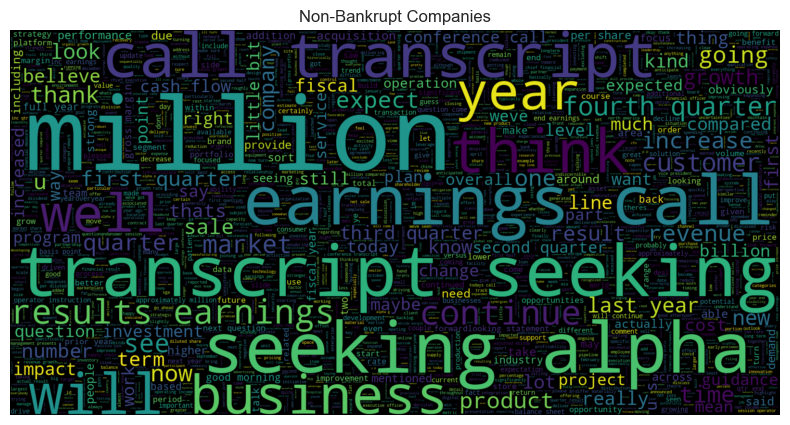

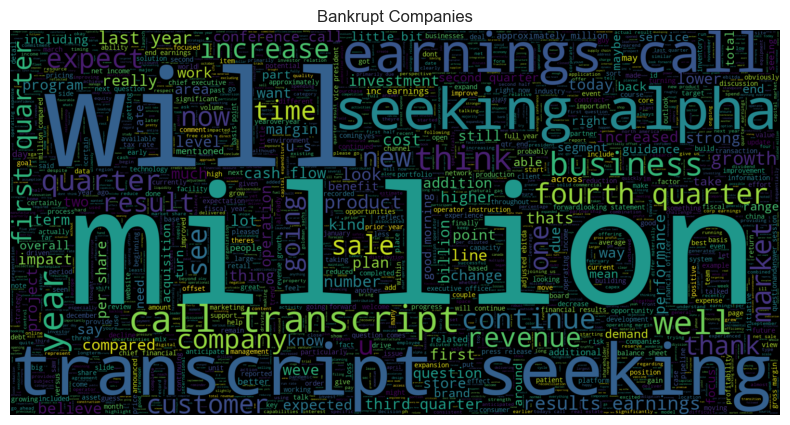

In [10]:
# Code to display wordcloud of non-bankrupt and bankrupt data
def display_wordcloud(df, label, title, max_words=5000, width=1600, height=800, fig_size=(10, 5)):
    # Prepare the data from DataFrame
    data = " ".join(df[df['label'] == label]['text'])

    # Create a WordCloud object with specified configurations
    wc = WordCloud(max_words=max_words, width=width, height=height, background_color='black')

    # Generate the word cloud from the text data
    wc.generate(data)

    # Set up the size of the figure
    plt.figure(figsize=fig_size)

    # Display the generated WordCloud image
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')  # Hide the axis
    
    # Display the title
    plt.title(title, fontsize=12)
    
    plt.show()  # Display the figure

# Display wordcloud of non-bankrupt words
display_wordcloud(df, label=0, title='Non-Bankrupt Companies')

# Display wordcloud of bankrupt words
display_wordcloud(df, label=1, title='Bankrupt Companies')

*It appears that the word clouds for bankrupt and non-bankrupt cases don't show significant differences, likely because they're both rooted in the financial sector and therefore share similar jargon. Further text preprocessing using spaCy has been deployed to pinpoint more distinctive terms between the two classes. Establishing a linguistic pipeline would be beneficial to thoroughly examine each word and its attributes, enhancing our understanding of the textual data.*

*The below code produces a new dataframe (df_lemmas) which contains transcripts that have been linguistically analyzed with spaCy. This means each transcript has been broken down into tokens and tagged for parts of speech, making them ready for further natural language processing (NLP) tasks like sentiment analysis. The code also focuses on creating new features based on the lemmas (base forms of words) in these transcripts.*

In [11]:
# Code to define a function to process 'text' in df column using the spaCy model
# Load the spaCy medium-sized English model
nlp = spacy.load("en_core_web_md")

def process_transcript(transcript):
    # Process the transcript using spaCy
    doc = nlp(transcript)
    
    # Extract lemmas
    lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
    
    # Count total lemmas
    total_lemmas = len(lemmas)
    
    # Count unique lemmas
    unique_lemmas = len(set(lemmas))
    
    # Calculate ratio of total lemmas to unique lemmas
    lemma_ratio = total_lemmas / unique_lemmas if unique_lemmas > 0 else 0
    
    return lemmas, total_lemmas, unique_lemmas, lemma_ratio

# Apply the function to each transcript in the 'text' column
df_lemmas = df.copy()
df_lemmas[['lemmas', 'total_lemmas', 'unique_lemmas', 'lemma_ratio']] = df_lemmas['text'].apply(lambda x: pd.Series(process_transcript(x)))

In [12]:
# View the dataframe with new columns of lemma statistics 
df_lemmas.sample(n=5, random_state=42)

,title,text,label,sentiment,lemmas,total_lemmas,unique_lemmas,lemma_ratio
753,"Itron, Inc. (ITRI) Q1 2009 Earnings Call Trans...",steve sanders stephens inc. john quealy canacc...,0,Non-Bankrupt,"[steve, sanders, stephens, inc, john, quealy, ...",5125,992,5.166331
519,"The Williams Companies, Inc. (NYSE:WMB) 2020 W...",praneeth satish okay good afternoon. and thank...,1,Bankrupt,"[praneeth, satish, okay, good, afternoon, and,...",5458,872,6.259174
210,Ashford Hospitality Trust (NYSE:AHT) Q4 2007 E...,harry sullivan senior vice president and princ...,0,Non-Bankrupt,"[harry, sullivan, senior, vice, president, and...",5047,970,5.203093
943,Comfort Systems USA Q4 2007 Earnings Call Febr...,matt duncan stephens inc david yuschak smh cap...,0,Non-Bankrupt,"[matt, duncan, stephens, inc, david, yuschak, ...",5187,899,5.769744
915,PHH Corp. (NYSE:PHH) Q4 2007 Earnings Call Feb...,jordan hymowitz philadelphia financial gabriel...,1,Bankrupt,"[jordan, hymowitz, philadelphia, financial, ga...",5392,888,6.072072


*Next, key statistics of the lemmas will be explored to examine if there are any differences between the transcripts. These include:*

*- **Average Length**: This refers to the average length of the transcripts, determined by counting the number of lemmas in each transcript.*

*- **Average Vocab Size**: Vocab size is the size of the vocabulary, represented by the total count of unique lemmas across all transcripts.*

*- **Average Diversity**: Diversity is a measure of how varied the language used in the transcripts is. It's calculated by dividing the total number of lemmas by the number of unique lemmas. A higher number indicates more frequent repetition of words.*

In [13]:
# Code to calculate statistics on word lemmas
def calculate_lemma_statistics(df):
    # Group the data by the 'sentiment' column and calculate mean for the relevant columns
    stats = df.groupby('sentiment')[['total_lemmas', 'unique_lemmas', 'lemma_ratio']].mean()

    # Rename columns for clarity
    stats = stats.rename(columns={
        'total_lemmas': 'Average Length',
        'unique_lemmas': 'Average Vocab Size',
        'lemma_ratio': 'Average Diversity'
    })
    
    return stats

# Calculate statistics for each class and display the results
stats = calculate_lemma_statistics(df_lemmas)
print("Lemma Statistics by Sentiment Class:\n", stats)

Lemma Statistics by Sentiment Class:
               Average Length  Average Vocab Size  Average Diversity
sentiment                                                          
Bankrupt         4749.157556          890.951768           5.342246
Non-Bankrupt     4672.939007          879.822695           5.314187


*The average length of the transcripts, determined by counting the number of lemmas in each transcript, is seen to be more for the bankrupt companies than the non-bankrupt companies. This could be because bankruptcy situations are complex, requiring detailed explanations about finances, laws, and operations. Additionally, companies in bankruptcy might be under more rules and need to give thorough details during their earnings calls, leading to transcripts with broader vocabulary sizes. Also, companies in financial distress often repeat key points to underscore transparency and shape stakeholder perceptions, which could lead to a higher frequency of word repetition.*

*Next, the Part-of-Speech (POS) tags will be visualized using word clouds to gain insights into the text structure. This helps in understanding how different types of words are used in the text, particularly for sentiment analysis, as certain types of words can be more indicative of sentiment than others.*

In [ ]:
# Create a word cloud for the Part-of-Speech (POS) tags in both bankrupt and non-bankrupt transcripts
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Define the POS tags
pos_tags = ['ADJ', 'ADV', 'VERB', 'NOUN']
pos_names = ['Adjectives', 'Adverbs', 'Verbs', 'Nouns']

# Function to extract words of particular POS tags from a document
def extract_pos_words(text, pos_tags):
    doc = nlp(text)
    pos_words = defaultdict(list)
    for token in doc:
        if token.pos_ in pos_tags:
            pos_words[token.pos_].append(token.lemma_)
    return pos_words

# Initialize a dictionary to hold all words for each POS
all_pos_words = defaultdict(list)

# Iterate through each document in the 'text' column
for text in df['text']:
    pos_words = extract_pos_words(text, pos_tags)
    for pos, words in pos_words.items():
        all_pos_words[pos] += words

# Function to create and display a word cloud
def display_wordcloud(words, title):
    word_string = ' '.join(words)
    wc = WordCloud(max_words=5000, width=1600, height=800, background_color='black')
    wc.generate(word_string)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=12)
    plt.axis('off')
    plt.show()

# Create and display the word clouds for each POS category
for pos_tag, pos_name in zip(pos_tags, pos_names):
    display_wordcloud(all_pos_words[pos_tag], f'Word Cloud for {pos_name}')

*The word clouds above show that adjectives are the most useful in identifying sentiment related to company bankruptcy. This aligns with much research suggesting adjectives are key in sentiment analysis. However, due to limited data, using an adjective-based feature space could be too sparse for the analysis.* 

*Next, various modeling techniques will be examined to identify the most suitable approach for the sentiment analysis, given the available data. Naive Bayes, Random Forest Classifier, Support Vector Classifier (SVC), and Logistic Regression classification models have been selected because of their good performance on text data, as reported in the literature. Additionally, F1-Score, a weighted average of precision and recall, will be used to evaluate models' performances as this more useful for unbalanced classes than accuracy.*

### Model 1 - Features based on text and lemma statistics
- The initial modeling strategy will focus on using lemma statistics as features, influenced by insights from the exploratory data analysis which highlighted slight differences in bankrupt and non-bankrupt transcripts.
- Model classifiers: MultinomialNB, RandomForestClassifier, SVC, LogisticRegression
- Model performance metric: F1 Score

In [15]:
# Split the data into training and test sets with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    df_lemmas['text'], 
    df_lemmas['label'], 
    train_size=0.8, 
    random_state=42, 
    stratify=df_lemmas['label']  # Ensure the distribution of classes in train and test sets mirrors the original dataset
)

# Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the 'text' column in training data to get TF-IDF features
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Only transform the 'text' column in test data
tfidf_test = tfidf_vectorizer.transform(X_test)

# Convert the TF-IDF matrices to DataFrames
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=X_train.index)
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=X_test.index)

# Concatenate the TF-IDF features with 'total_lemmas', 'unique_lemmas', and 'lemma_ratio' from df_lemmas for both train and test
X_train_lemmas = pd.concat([tfidf_train_df, df_lemmas.loc[X_train.index, ['total_lemmas', 'unique_lemmas', 'lemma_ratio']]], axis=1)
X_test_lemmas = pd.concat([tfidf_test_df, df_lemmas.loc[X_test.index, ['total_lemmas', 'unique_lemmas', 'lemma_ratio']]], axis=1)

# Print lengths of the split data to verify the split
print(f"Length of X_train_lemmas: {len(X_train_lemmas)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of X_test_lemmas: {len(X_test_lemmas)}")
print(f"Length of y_test: {len(y_test)}")

# Verify the class distribution in the training and test sets
class_distribution_train = y_train.value_counts(normalize=True)
class_distribution_test = y_test.value_counts(normalize=True)

print("\nClass Distribution in Training Set:")
print(class_distribution_train)

print("\nClass Distribution in Test Set:")
print(class_distribution_test)

Length of X_train_lemmas: 812
Length of y_train: 812
Length of X_test_lemmas: 204
Length of y_test: 204

Class Distribution in Training Set:
label
0    0.69335
1    0.30665
Name: proportion, dtype: float64

Class Distribution in Test Set:
label
0    0.696078
1    0.303922
Name: proportion, dtype: float64


In [16]:
# Code to define a model pipeline (for features based on text and lemma statistics) to streamline the workflow
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

results = []

for classifier_name, classifier in classifiers.items():
    text_classification_pipeline = Pipeline([
        ('classifier', classifier),
    ])

    # Fit the pipeline to the training data
    text_classification_pipeline.fit(X_train_lemmas, y_train)
    
    # Predict the labels for the training and test data using the trained pipeline
    train_predicted_labels = text_classification_pipeline.predict(X_train_lemmas)
    test_predicted_labels = text_classification_pipeline.predict(X_test_lemmas)

    # Evaluate performance of the pipeline for training and test data
    train_accuracy = metrics.accuracy_score(y_train, train_predicted_labels)
    test_accuracy = metrics.accuracy_score(y_test, test_predicted_labels)
    confusion_matrix = metrics.confusion_matrix(y_test, test_predicted_labels)
    classification_report = metrics.classification_report(y_test, test_predicted_labels, zero_division=0)

    # Store results
    results.append({
        'Classifier': classifier_name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Confusion Matrix': confusion_matrix,
        'Classification Report': classification_report
    })

    print(f"\nClassifier: {classifier_name}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    print("Confusion Matrix:")
    print(confusion_matrix)
    print("Classification Report:")
    print(classification_report)


Classifier: MultinomialNB
Train Accuracy: 0.6933497536945813
Test Accuracy: 0.696078431372549
Confusion Matrix:
[[142   0]
 [ 62   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       142
           1       0.00      0.00      0.00        62

    accuracy                           0.70       204
   macro avg       0.35      0.50      0.41       204
weighted avg       0.48      0.70      0.57       204


Classifier: RandomForestClassifier
Train Accuracy: 0.9741379310344828
Test Accuracy: 0.7352941176470589
Confusion Matrix:
[[136   6]
 [ 48  14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.83       142
           1       0.70      0.23      0.34        62

    accuracy                           0.74       204
   macro avg       0.72      0.59      0.59       204
weighted avg       0.73      0.74      0.68       204


Classifier: SVC
T

*All the models have difficulty predicting bankruptcy based solely on transcript lemmas and their statistics. The struggle to accurately predict bankruptcy might come from the limited size of the data, suggesting that the available information may not fully capture the complexities or distinguishing features needed for effective prediction based on lemmas in the transcripts.*

### Model 2 - Features based on text only (no hyperparameter tuning)
- The next approach will be to model using solely the 'text' column as the feature. This might offer a more general perspective compared to incorporating additional features such as lemma statistics.
- Model classifiers: MultinomialNB, RandomForestClassifier, SVC, LogisticRegression
- Model performance metric: F1 Score

In [26]:
# Split the data into training and test sets with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], 
    df['label'], 
    train_size=0.8, 
    random_state=42, 
    stratify=df['label']  # Ensure the distribution of classes in train and test sets mirrors the original dataset
)

# Print lengths of the split data to verify the split
print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_test: {len(y_test)}")

# Verify the class distribution in the training and test sets
class_distribution_train = y_train.value_counts(normalize=True)
class_distribution_test = y_test.value_counts(normalize=True)

print("\nClass Distribution in Training Set:")
print(class_distribution_train)

print("\nClass Distribution in Test Set:")
print(class_distribution_test)

Length of X_train: 812
Length of y_train: 812
Length of X_test: 204
Length of y_test: 204

Class Distribution in Training Set:
label
0    0.69335
1    0.30665
Name: proportion, dtype: float64

Class Distribution in Test Set:
label
0    0.696078
1    0.303922
Name: proportion, dtype: float64


In [30]:
# Code to define a model pipeline (for features based on text only) to streamline the workflow
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

results = []

for classifier_name, classifier in classifiers.items():
    text_classification_pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('binarizer', Binarizer()),
        ('classifier', classifier),
    ])

    # Fit the pipeline to the training data
    text_classification_pipeline.fit(X_train, y_train)
    
    # Predict the labels for the training and test data using the trained pipeline
    train_predicted_labels = text_classification_pipeline.predict(X_train)
    test_predicted_labels = text_classification_pipeline.predict(X_test)

    # Evaluate performance of the pipeline for training and test data
    train_accuracy = metrics.accuracy_score(y_train, train_predicted_labels)
    test_accuracy = metrics.accuracy_score(y_test, test_predicted_labels)
    confusion_matrix = metrics.confusion_matrix(y_test, test_predicted_labels)
    classification_report = metrics.classification_report(y_test, test_predicted_labels)

    # Store results
    results.append({
        'Classifier': classifier_name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Confusion Matrix': confusion_matrix,
        'Classification Report': classification_report
    })

    print(f"\nClassifier: {classifier_name}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    print("Confusion Matrix:")
    print(confusion_matrix)
    print("Classification Report:")
    print(classification_report)


Classifier: MultinomialNB
Train Accuracy: 0.9507389162561576
Test Accuracy: 0.7450980392156863
Confusion Matrix:
[[137   5]
 [ 47  15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84       142
           1       0.75      0.24      0.37        62

    accuracy                           0.75       204
   macro avg       0.75      0.60      0.60       204
weighted avg       0.75      0.75      0.70       204


Classifier: RandomForestClassifier
Train Accuracy: 0.9729064039408867
Test Accuracy: 0.7450980392156863
Confusion Matrix:
[[138   4]
 [ 48  14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.97      0.84       142
           1       0.78      0.23      0.35        62

    accuracy                           0.75       204
   macro avg       0.76      0.60      0.60       204
weighted avg       0.75      0.75      0.69       204


Classifier: SVC


In [31]:
# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Sort the DataFrame by the 'Accuracy' column
results_df = results_df.sort_values('Test Accuracy', ascending=True)

# Display results in a table
results_df[['Classifier', 'Train Accuracy', 'Test Accuracy']]

,Classifier,Train Accuracy,Test Accuracy
0,MultinomialNB,0.950739,0.745098
1,RandomForestClassifier,0.972906,0.745098
2,SVC,0.881773,0.745098
3,LogisticRegression,0.972906,0.754902


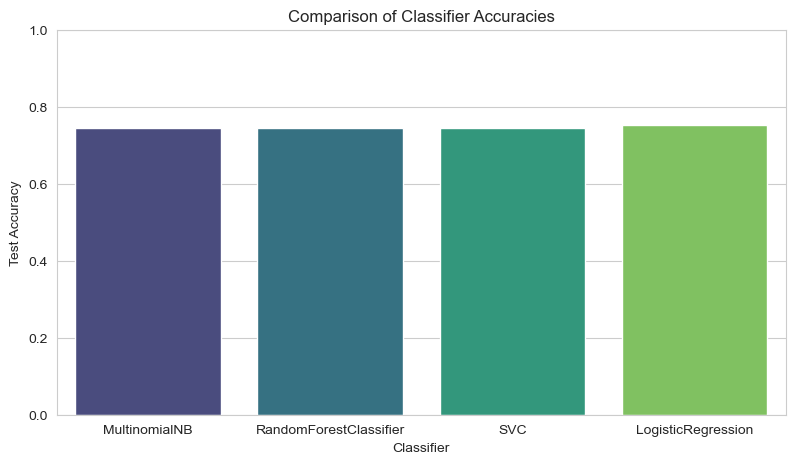

In [36]:
# Visualization to compare accuracy scores using seaborn
sns.set_style("whitegrid")

plt.figure(figsize=(9.4, 5))
sns.barplot(y='Test Accuracy', x='Classifier', data=results_df, palette='viridis')
plt.ylabel('Test Accuracy')
plt.xlabel('Classifier')
plt.title('Comparison of Classifier Accuracies')
plt.ylim(0, 1)  # Set the limit for the y-axis
plt.show()

#### Specific Observations for Each Classifier:
1. **MultinomialNB:**
   - High Train Accuracy (95.07%) but lower Test Accuracy (74.51%), indicating potential overfitting.
   - The Confusion Matrix and Classification Report show good precision for both classes but poor recall for class 1, suggesting it's good at predicting class 0 but not class 1.
2. **RandomForestClassifier:**
   - Very high Train Accuracy (97.29%), similar Test Accuracy (74.51%) as MultinomialNB, potentially overfitting as well.
   - The metrics are quite similar to MultinomialNB, with slightly better performance in predicting class 1 but still not optimal.
3. **SVC:**
   - Lower Train Accuracy (88.18%) compared to the other models but the same Test Accuracy (74.51%), suggesting better generalization.
   - Better precision for class 1 compared to the other models but still suffers from low recall for class 1.
4. **LogisticRegression:**
   - High Train Accuracy (97.29%) and the highest Test Accuracy (75.49%) among the models, indicating better performance.
   - Shows a better balance in precision and recall for class 1 compared to other models but still has room for improvement.

**General Observations:**
- All models have similar Test Accuracy (~74.51%), with LogisticRegression slightly higher.
- There's a consistent issue with low recall for class 1 across all models, meaning many instances of class 1 are being missed.
- The high training accuracy and lower testing accuracy for some models suggest overfitting, where the model performs well on the training data but not as well on new, unseen data.
- Improving the models might involve gathering more data, especially for class 1, or trying different modeling techniques or hyperparameters to balance out the recall and precision for both classes.

### Model 3 - SMOTE - Features based on text only (no hyperparameter tuning)
- The next step is to implement SMOTE, while maintaining the same feature set as the previous model, to assess if there's an enhancement in performance.
- Model classifiers: MultinomialNB, RandomForestClassifier, SVC, LogisticRegression
- Model performance metric: F1 Score

In [ ]:
# Split the data into training and test sets with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], 
    df['label'], 
    train_size=0.8, 
    random_state=42, 
    stratify=df['label']  # Ensure the distribution of classes in train and test sets mirrors the original dataset
)

# Print lengths of the split data to verify the split
print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_test: {len(y_test)}")

# Verify the class distribution in the training and test sets
class_distribution_train = y_train.value_counts(normalize=True)
class_distribution_test = y_test.value_counts(normalize=True)

print("\nClass Distribution in Training Set:")
print(class_distribution_train)

print("\nClass Distribution in Test Set:")
print(class_distribution_test)

In [40]:
# Code to implement SMOTE for oversampling
# Ignore FutureWarning raised by KMeans about the 'n_init' parameter
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create a pipeline to streamline the workflow
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

results = []

for classifier_name, classifier in classifiers.items():
    text_classification_imbpipeline = ImbPipeline([
        ('vectorizer', TfidfVectorizer()),
        ('binarizer', Binarizer()),
        ('smote', KMeansSMOTE(random_state=42, cluster_balance_threshold=0.3)),
        ('classifier', classifier),
    ])

    # Fit the pipeline to the training data
    text_classification_imbpipeline.fit(X_train, y_train)
    
    # Predict the labels for the training and test data using the trained pipeline
    train_predicted_labels = text_classification_imbpipeline.predict(X_train)
    test_predicted_labels = text_classification_imbpipeline.predict(X_test)

    # Evaluate performance of the pipeline for training and test data
    train_accuracy = metrics.accuracy_score(y_train, train_predicted_labels)
    test_accuracy = metrics.accuracy_score(y_test, test_predicted_labels)
    confusion_matrix = metrics.confusion_matrix(y_test, test_predicted_labels)
    classification_report = metrics.classification_report(y_test, test_predicted_labels)

    # Store results
    results.append({
        'Classifier': classifier_name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Confusion Matrix': confusion_matrix,
        'Classification Report': classification_report
    })

    print(f"\nClassifier: {classifier_name}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    print("Confusion Matrix:")
    print(confusion_matrix)
    print("Classification Report:")
    print(classification_report)


Classifier: MultinomialNB
Train Accuracy: 0.9002463054187192
Test Accuracy: 0.7401960784313726
Confusion Matrix:
[[130  12]
 [ 41  21]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       142
           1       0.64      0.34      0.44        62

    accuracy                           0.74       204
   macro avg       0.70      0.63      0.64       204
weighted avg       0.72      0.74      0.71       204


Classifier: RandomForestClassifier
Train Accuracy: 0.9729064039408867
Test Accuracy: 0.7352941176470589
Confusion Matrix:
[[136   6]
 [ 48  14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.83       142
           1       0.70      0.23      0.34        62

    accuracy                           0.74       204
   macro avg       0.72      0.59      0.59       204
weighted avg       0.73      0.74      0.68       204


Classifier: SVC


*SMOTE (Synthetic Minority Over-sampling Technique) will not be implemented in the model as it has been determined above that it does not effectively enhance any of the model's performance in this context. While SMOTE is generally used to address class imbalance by generating synthetic samples for the bankrupt class, in this specific case, it does not contribute to a significant improvement in the model's recall, meaning it does not adequately increase the true positive rate for the bankrupt class. Consequently, alternative strategies need to be considered to tackle the issues of class imbalance and to enhance the model's recall and generalization capabilities.*

### Model 4 - K-Fold CV - Features based on text only (no hyperparameter tuning)
- To comprehensively evaluate the classifiers' performances across the entire dataset, k-fold cross-validation with the same feature set will be implemented.
- Model classifiers: MultinomialNB, RandomForestClassifier, SVC, LogisticRegression
- Model performance metric: F1 Score

In [53]:
# Code to run k-fold cross validation
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

results = []
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
texts = df['text'].values
labels = df['label'].values

for classifier_name, classifier in classifiers.items():
    text_classification_pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('binarizer', Binarizer()),
        ('classifier', classifier),
    ])

    fold_train_accuracies = []
    fold_test_accuracies = []
    fold_predictions = []
    fold_true_labels = []  # Store true labels for each fold
    
    for train_index, test_index in kf.split(texts):
        X_train, X_test = texts[train_index], texts[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # Fit the pipeline to the training data
        text_classification_pipeline.fit(X_train, y_train)

        # Predict and evaluate on the training set
        train_predicted_labels = text_classification_pipeline.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predicted_labels)
        fold_train_accuracies.append(train_accuracy)

        # Predict and evaluate on the test set
        test_predicted_labels = text_classification_pipeline.predict(X_test)
        test_accuracy = accuracy_score(y_test, test_predicted_labels)
        fold_test_accuracies.append(test_accuracy)
        fold_predictions.extend(test_predicted_labels)
        fold_true_labels.extend(y_test)  # Add true labels for confusion matrix and classification report

    # Aggregate results
    average_train_accuracy = np.mean(fold_train_accuracies)
    average_test_accuracy = np.mean(fold_test_accuracies)
    conf_matrix = confusion_matrix(fold_true_labels, fold_predictions)  # Use true labels of folds
    classif_report = classification_report(fold_true_labels, fold_predictions)

    # Store results
    results.append({
        'Classifier': classifier_name,
        'Average Train Accuracy': average_train_accuracy,
        'Average Test Accuracy': average_test_accuracy,
        'Confusion Matrix': conf_matrix,
        'Classification Report': classif_report
    })

    print(f"\nClassifier: {classifier_name}")
    print(f"Average Train Accuracy: {average_train_accuracy:.2f}")
    print(f"Average Test Accuracy: {average_test_accuracy:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classif_report)


Classifier: MultinomialNB
Average Train Accuracy: 0.95
Average Test Accuracy: 0.74
Confusion Matrix:
[[671  34]
 [234  77]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       705
           1       0.69      0.25      0.36       311

    accuracy                           0.74      1016
   macro avg       0.72      0.60      0.60      1016
weighted avg       0.73      0.74      0.69      1016


Classifier: RandomForestClassifier
Average Train Accuracy: 0.97
Average Test Accuracy: 0.73
Confusion Matrix:
[[675  30]
 [242  69]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.83       705
           1       0.70      0.22      0.34       311

    accuracy                           0.73      1016
   macro avg       0.72      0.59      0.58      1016
weighted avg       0.72      0.73      0.68      1016


Classifier: SVC
Average Train Accuracy: 

*The Logistic Regression model outperforms all others, consistently achieving an F1 score over 40% in bankruptcy prediction. This performance aligns with the findings from the earlier Model 2, which was evaluated without cross-validation. Based on this observation, Logistic Regression has been chosen for additional hyperparameter tuning. This step aims to not only enhance the model's performance further but also to address the high average training accuracy, which hints at potential overfitting. The goal is to achieve better generalization in the model's predictive capabilities.*

### Model 5 - LR with K-Fold CV - Features based on text only (with hyperparameter tuning)
- Logistic Regression has been chosen for additional hyperparameter tuning. This step aims to not only enhance the model's performance further but also to address the high average training accuracy, which hints at potential overfitting. The goal is to achieve better generalization in the model's predictive capabilities.
- Model classifier: LogisticRegression
- Model performance metric: F1 Score

In [61]:
# LR with K-Fold CV - Evaluate using AUC (Area Under the Curve)
# Define the Logistic Regression classifier
classifier = LogisticRegression(max_iter=1000)

k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
texts = df['text'].values
labels = df['label'].values

text_classification_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('binarizer', Binarizer()),
    ('classifier', classifier),
])

fold_train_accuracies = []
fold_test_accuracies = []
fold_auc_scores = []
fold_true_labels = []  # Store true labels for each fold
fold_predicted_probabilities = []  # Store predicted probabilities for AUC calculation

for train_index, test_index in kf.split(texts):
    X_train, X_test = texts[train_index], texts[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Fit the pipeline to the training data
    text_classification_pipeline.fit(X_train, y_train)

    # Predict and evaluate on the training set
    train_predicted_labels = text_classification_pipeline.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predicted_labels)
    fold_train_accuracies.append(train_accuracy)

    # Predict and evaluate on the test set
    test_predicted_labels = text_classification_pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predicted_labels)
    test_predicted_probabilities = text_classification_pipeline.predict_proba(X_test)[:, 1]
    fold_test_accuracies.append(test_accuracy)
    fold_true_labels.extend(y_test)  # Add true labels for AUC calculation
    fold_predicted_probabilities.extend(test_predicted_probabilities)  # Add probabilities for AUC calculation

    # Compute AUC for this fold
    fold_auc = roc_auc_score(y_test, test_predicted_probabilities)
    fold_auc_scores.append(fold_auc)

# Aggregate results
average_train_accuracy = np.mean(fold_train_accuracies)
average_test_accuracy = np.mean(fold_test_accuracies)
average_auc_score = np.mean(fold_auc_scores)

# Convert list to NumPy array for element-wise comparison
fold_predicted_classes = np.array(fold_predicted_probabilities) > 0.5
conf_matrix = confusion_matrix(fold_true_labels, fold_predicted_classes)
classif_report = classification_report(fold_true_labels, fold_predicted_classes)

print(f"\nClassifier: Logistic Regression")
print(f"Average Train Accuracy: {average_train_accuracy:.2f}")
print(f"Average Test Accuracy: {average_test_accuracy:.2f}")
print(f"Average AUC Score: {average_auc_score:.2f}")

# Print AUC scores for each fold
for i, auc in enumerate(fold_auc_scores, 1):
    print(f'AUC Score for Fold {i}: {auc:.2f}')

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classif_report)


Classifier: Logistic Regression
Average Train Accuracy: 0.97
Average Test Accuracy: 0.72
Average AUC Score: 0.67
AUC Score for Fold 1: 0.66
AUC Score for Fold 2: 0.60
AUC Score for Fold 3: 0.72
AUC Score for Fold 4: 0.63
AUC Score for Fold 5: 0.76
AUC Score for Fold 6: 0.63
AUC Score for Fold 7: 0.58
AUC Score for Fold 8: 0.71
AUC Score for Fold 9: 0.71
AUC Score for Fold 10: 0.68
Confusion Matrix:
[[631  74]
 [210 101]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       705
           1       0.58      0.32      0.42       311

    accuracy                           0.72      1016
   macro avg       0.66      0.61      0.62      1016
weighted avg       0.70      0.72      0.69      1016



In [62]:
# Include regularization strength parameter 'C' in Logistic Regression model
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
texts = df['text'].values
labels = df['label'].values

# Values of C to iterate over
c_values = [0.001, 0.01, 0.1, 0.5, 1, 10]

# Loop over each value of C
for c in c_values:
    # Define the Logistic Regression classifier with current C
    classifier = LogisticRegression(C=c, max_iter=1000)

    text_classification_pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('binarizer', Binarizer()),
        ('classifier', classifier),
    ])

    fold_auc_scores = []

    for train_index, test_index in kf.split(texts):
        X_train, X_test = texts[train_index], texts[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # Fit the pipeline to the training data
        text_classification_pipeline.fit(X_train, y_train)

        # Predict probabilities on the test set
        test_predicted_probabilities = text_classification_pipeline.predict_proba(X_test)[:, 1]

        # Compute AUC for this fold and append to list
        fold_auc = roc_auc_score(y_test, test_predicted_probabilities)
        fold_auc_scores.append(fold_auc)

    # Aggregate results for current C
    mean_auc_score = np.mean(fold_auc_scores)
    std_auc_score = np.std(fold_auc_scores)

    print(f"\nClassifier: Logistic Regression with C={c}")
    print(f"Mean AUC Score: {mean_auc_score:.2f}")
    print(f"AUC Score Standard Deviation: {std_auc_score:.2f}")


Classifier: Logistic Regression with C=0.001
Mean AUC Score: 0.67
AUC Score Standard Deviation: 0.03

Classifier: Logistic Regression with C=0.01
Mean AUC Score: 0.68
AUC Score Standard Deviation: 0.04

Classifier: Logistic Regression with C=0.1
Mean AUC Score: 0.67
AUC Score Standard Deviation: 0.05

Classifier: Logistic Regression with C=0.5
Mean AUC Score: 0.67
AUC Score Standard Deviation: 0.05

Classifier: Logistic Regression with C=1
Mean AUC Score: 0.67
AUC Score Standard Deviation: 0.05

Classifier: Logistic Regression with C=10
Mean AUC Score: 0.67
AUC Score Standard Deviation: 0.06


What we see is that after C = 0.1, the average AUC is the same and doesn’t grow anymore.
However, the standard deviation is smaller for C = 0.5 than for C = 0.1, so we should use that. The reason we preferC= 0.5 toC= 1 andC= 10 is simple: when the C parameter is small, the model is more regularized. The weights of this model are more restricted, so in general, they are smaller. Small weights in the model give us additional assurance that the model will behave well when we use it on real data. So we select C = 0.5.

In [67]:
# GridSearchCV
# Define the Logistic Regression classifier
classifier = LogisticRegression(max_iter=1000)

# Define the pipeline
text_classification_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('binarizer', Binarizer()),
    ('classifier', classifier),
])

# Define the parameter grid
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']  # 'liblinear' is a good choice for small datasets and 'l1' penalty
}

# Define the scoring function
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Create a GridSearchCV object
grid_search = GridSearchCV(text_classification_pipeline, param_grid, scoring=auc_scorer, cv=kf, verbose=1)

# Fit the grid search to the data
grid_search.fit(texts, labels)

# Get the best classifier
best_classifier = grid_search.best_estimator_

# Get the best parameters and the best AUC score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best AUC Score: {best_score}")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best AUC Score: 0.67969266419145


In [68]:
# LR with K-Fold CV - Evaluate using AUC (Area Under the Curve)
# Define the Logistic Regression classifier
classifier = LogisticRegression(max_iter=1000)

k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
texts = df['text'].values
labels = df['label'].values

text_classification_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('binarizer', Binarizer()),
    ('classifier', classifier),
])

fold_train_accuracies = []
fold_test_accuracies = []
fold_auc_scores = []
fold_true_labels = []  # Store true labels for each fold
fold_predicted_probabilities = []  # Store predicted probabilities for AUC calculation

for train_index, test_index in kf.split(texts):
    X_train, X_test = texts[train_index], texts[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Fit the pipeline to the training data
    text_classification_pipeline.fit(X_train, y_train)

    # Predict and evaluate on the training set
    train_predicted_labels = text_classification_pipeline.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predicted_labels)
    fold_train_accuracies.append(train_accuracy)

    # Predict and evaluate on the test set
    test_predicted_labels = text_classification_pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predicted_labels)
    test_predicted_probabilities = text_classification_pipeline.predict_proba(X_test)[:, 1]
    fold_test_accuracies.append(test_accuracy)
    fold_true_labels.extend(y_test)  # Add true labels for AUC calculation
    fold_predicted_probabilities.extend(test_predicted_probabilities)  # Add probabilities for AUC calculation

    # Compute AUC for this fold
    fold_auc = roc_auc_score(y_test, test_predicted_probabilities)
    fold_auc_scores.append(fold_auc)

# Aggregate results
average_train_accuracy = np.mean(fold_train_accuracies)
average_test_accuracy = np.mean(fold_test_accuracies)
average_auc_score = np.mean(fold_auc_scores)

# Convert list to NumPy array for element-wise comparison
fold_predicted_classes = np.array(fold_predicted_probabilities) > 0.68
conf_matrix = confusion_matrix(fold_true_labels, fold_predicted_classes)
classif_report = classification_report(fold_true_labels, fold_predicted_classes)

print(f"\nClassifier: Logistic Regression")
print(f"Average Train Accuracy: {average_train_accuracy:.2f}")
print(f"Average Test Accuracy: {average_test_accuracy:.2f}")
print(f"Average AUC Score: {average_auc_score:.2f}")

# Print AUC scores for each fold
for i, auc in enumerate(fold_auc_scores, 1):
    print(f'AUC Score for Fold {i}: {auc:.2f}')

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classif_report)


Classifier: Logistic Regression
Average Train Accuracy: 0.97
Average Test Accuracy: 0.72
Average AUC Score: 0.67
AUC Score for Fold 1: 0.66
AUC Score for Fold 2: 0.60
AUC Score for Fold 3: 0.72
AUC Score for Fold 4: 0.63
AUC Score for Fold 5: 0.76
AUC Score for Fold 6: 0.63
AUC Score for Fold 7: 0.58
AUC Score for Fold 8: 0.71
AUC Score for Fold 9: 0.71
AUC Score for Fold 10: 0.68
Confusion Matrix:
[[660  45]
 [226  85]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83       705
           1       0.65      0.27      0.39       311

    accuracy                           0.73      1016
   macro avg       0.70      0.60      0.61      1016
weighted avg       0.72      0.73      0.69      1016



In [ ]:
# LR with K-Fold CV - Evaluate using AUC (Area Under the Curve)
# Define the Logistic Regression classifier
classifier = LogisticRegression(max_iter=1000)

k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
texts = df['text'].values
labels = df['label'].values

text_classification_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('binarizer', Binarizer()),
    ('classifier', classifier),
])

fold_train_accuracies = []
fold_test_accuracies = []
fold_auc_scores = []
fold_true_labels = []  # Store true labels for each fold
fold_predicted_probabilities = []  # Store predicted probabilities for AUC calculation

for train_index, test_index in kf.split(texts):
    X_train, X_test = texts[train_index], texts[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Fit the pipeline to the training data
    text_classification_pipeline.fit(X_train, y_train)

    # Predict and evaluate on the training set
    train_predicted_labels = text_classification_pipeline.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predicted_labels)
    fold_train_accuracies.append(train_accuracy)

    # Predict and evaluate on the test set
    test_predicted_labels = text_classification_pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predicted_labels)
    test_predicted_probabilities = text_classification_pipeline.predict_proba(X_test)[:, 1]
    fold_test_accuracies.append(test_accuracy)
    fold_true_labels.extend(y_test)  # Add true labels for AUC calculation
    fold_predicted_probabilities.extend(test_predicted_probabilities)  # Add probabilities for AUC calculation

    # Compute AUC for this fold
    fold_auc = roc_auc_score(y_test, test_predicted_probabilities)
    fold_auc_scores.append(fold_auc)

# Aggregate results
average_train_accuracy = np.mean(fold_train_accuracies)
average_test_accuracy = np.mean(fold_test_accuracies)
average_auc_score = np.mean(fold_auc_scores)

# Convert list to NumPy array for element-wise comparison
fold_predicted_classes = np.array(fold_predicted_probabilities) > 0.5
conf_matrix = confusion_matrix(fold_true_labels, fold_predicted_classes)
classif_report = classification_report(fold_true_labels, fold_predicted_classes)

print(f"\nClassifier: Logistic Regression")
print(f"Average Train Accuracy: {average_train_accuracy:.2f}")
print(f"Average Test Accuracy: {average_test_accuracy:.2f}")
print(f"Average AUC Score: {average_auc_score:.2f}")

# Print AUC scores for each fold
for i, auc in enumerate(fold_auc_scores, 1):
    print(f'AUC Score for Fold {i}: {auc:.2f}')

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classif_report)

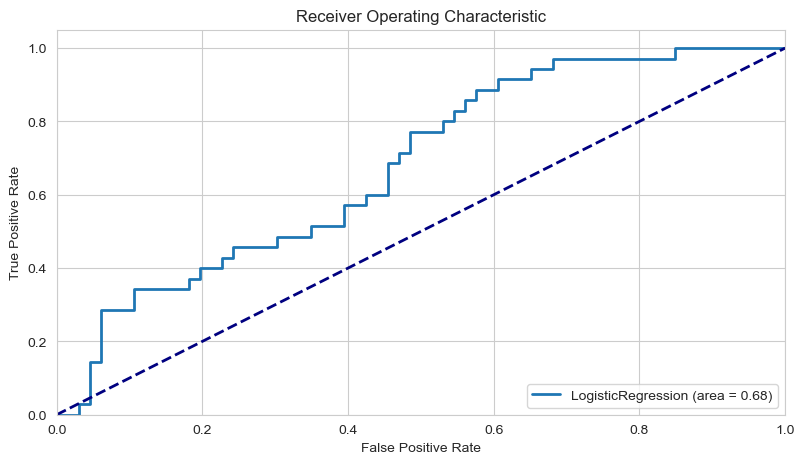

In [57]:
# Code for plotting ROC (Receiver Operating Characteristic) curve for the LogisticRegression model
# Define the Logistic Regression classifier
classifier = LogisticRegression(max_iter=1000)

# Create a pipeline
pipeline = make_pipeline(
    TfidfVectorizer(),
    Binarizer(),
    classifier
)

# Fit the model
pipeline.fit(X_train, y_train)

# Compute ROC curve and ROC area
# LogisticRegression has 'predict_proba' by default
probas_ = pipeline.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

# Create ROC curve plot
plt.figure(figsize=(9.4, 5))
plt.plot(fpr, tpr, lw=2, label=f'LogisticRegression (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Model 4 - K-Fold CV - Features based on text only (no hyperparameter tuning)
# Code to run k-fold cross validation
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

results = []
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
texts = df['text'].values
labels = df['label'].values

for classifier_name, classifier in classifiers.items():
    text_classification_pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('binarizer', Binarizer()),
        ('classifier', classifier),
    ])

    fold_train_accuracies = []
    fold_test_accuracies = []
    fold_predictions = []
    fold_true_labels = []  # Store true labels for each fold
    
    for train_index, test_index in kf.split(texts):
        X_train, X_test = texts[train_index], texts[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # Fit the pipeline to the training data
        text_classification_pipeline.fit(X_train, y_train)

        # Predict and evaluate on the training set
        train_predicted_labels = text_classification_pipeline.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predicted_labels)
        fold_train_accuracies.append(train_accuracy)

        # Predict and evaluate on the test set
        test_predicted_labels = text_classification_pipeline.predict(X_test)
        test_accuracy = accuracy_score(y_test, test_predicted_labels)
        fold_test_accuracies.append(test_accuracy)
        fold_predictions.extend(test_predicted_labels)
        fold_true_labels.extend(y_test)  # Add true labels for confusion matrix and classification report

    # Aggregate results
    average_train_accuracy = np.mean(fold_train_accuracies)
    average_test_accuracy = np.mean(fold_test_accuracies)
    conf_matrix = confusion_matrix(fold_true_labels, fold_predictions)  # Use true labels of folds
    classif_report = classification_report(fold_true_labels, fold_predictions)

    # Store results
    results.append({
        'Classifier': classifier_name,
        'Average Train Accuracy': average_train_accuracy,
        'Average Test Accuracy': average_test_accuracy,
        'Confusion Matrix': conf_matrix,
        'Classification Report': classif_report
    })

    print(f"\nClassifier: {classifier_name}")
    print(f"Average Train Accuracy: {average_train_accuracy:.2f}")
    print(f"Average Test Accuracy: {average_test_accuracy:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classif_report)

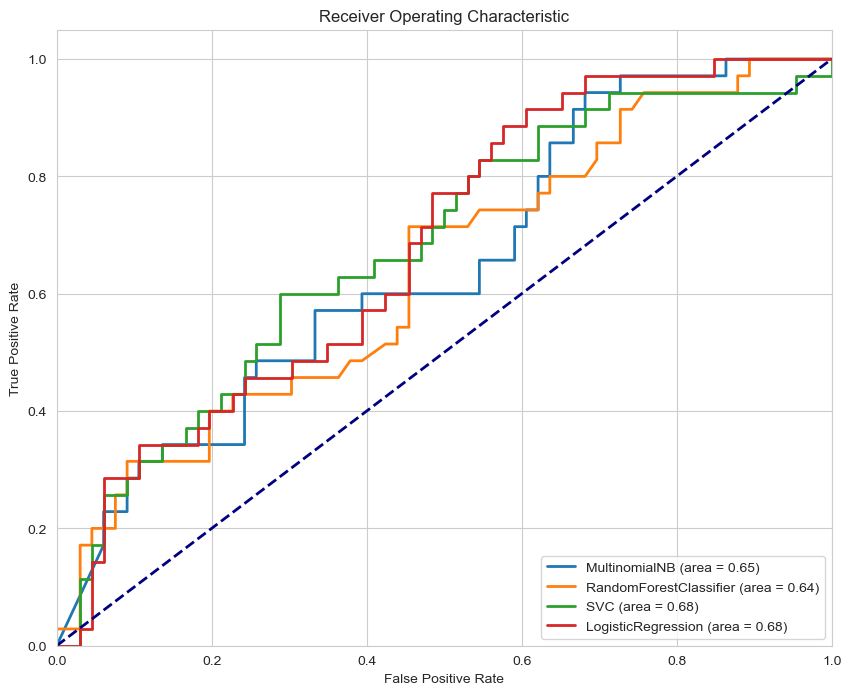

In [55]:
# ROC (Receiver Operating Characteristic) curve for each model on the same plot
# Define classifiers
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),  # Enable probability for ROC curve
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

# Create ROC curve plot
plt.figure(figsize=(10, 8))

for classifier_name, classifier in classifiers.items():
    # Define a pipeline for each classifier
    pipeline = make_pipeline(
        TfidfVectorizer(),
        Binarizer(),
        classifier
    )

    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Check if the classifier has either 'predict_proba' or 'decision_function'
    if hasattr(classifier, "predict_proba"):
        probas_ = pipeline.predict_proba(X_test)
        # Keep probabilities for the positive class only
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    elif hasattr(classifier, "decision_function"):
        # Use decision_function to compute ROC curve
        decision_scores = pipeline.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, decision_scores)
    else:
        # Classifier does not support predict_proba or decision_function
        continue
    
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{classifier_name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

An AUC of 0.7 is not very performant, and 0.6 indicates quite poor performance.

In [ ]:
# Computing the confusion table for different thresholds
scores = [] # Creates a list where we'll keep the results
thresholds = np.linspace(0, 1, 101) # Creates an array with different threshold values, and loops over them
for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

In [ ]:
# Code to update the Pipeline witn n-gram features and run k-fold cross validation
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

results = []
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
texts = df['text'].values
labels = df['label'].values

for classifier_name, classifier in classifiers.items():
    text_classification_pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
        ('binarizer', Binarizer()),
        ('classifier', classifier),
    ])

    fold_train_accuracies = []
    fold_test_accuracies = []
    fold_predictions = []
    
    for train_index, test_index in kf.split(texts):
        X_train, X_test = texts[train_index], texts[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # Fit the pipeline to the training data
        text_classification_pipeline.fit(X_train, y_train)

        # Predict and evaluate on the training set
        train_predicted_labels = text_classification_pipeline.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predicted_labels)
        fold_train_accuracies.append(train_accuracy)

        # Predict and evaluate on the test set
        test_predicted_labels = text_classification_pipeline.predict(X_test)
        test_accuracy = accuracy_score(y_test, test_predicted_labels)
        fold_test_accuracies.append(test_accuracy)
        fold_predictions.extend(test_predicted_labels)

    # Aggregate results
    average_train_accuracy = np.mean(fold_train_accuracies)
    average_test_accuracy = np.mean(fold_test_accuracies)
    conf_matrix = confusion_matrix(labels, fold_predictions)
    classif_report = classification_report(labels, fold_predictions)

    # Store results
    results.append({
        'Classifier': classifier_name,
        'Average Train Accuracy': average_train_accuracy,
        'Average Test Accuracy': average_test_accuracy,
        'Confusion Matrix': conf_matrix,
        'Classification Report': classif_report
    })

    print(f"\nClassifier: {classifier_name}")
    print(f"Average Train Accuracy: {average_train_accuracy:.2f}")
    print(f"Average Test Accuracy: {average_test_accuracy:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classif_report)

Naïve Bayes, unlike some other classifiers, can deal reasonably well with sparse features, such as distributions of words from a large vocabulary, where for each particular review only a few are present.

Before you can apply a trained model to the test set, you need to extract the features from the test set, which is achieved by applying CountVectorizer. To make sure that the algorithm counts the occurrences of the words from the vocabulary that it collected from the training data only (rather than collecting a new vocabulary and counting word occurrences based on it), omit the call to the fit method of the vectorizer and use only the transform bit—that is, you are transforming the raw contents of the test set reviews to the feature vectors, without fitting them into a new vocabulary. 

CountVectorizer is primarily used to implement the Bag of Words (BoW) model, and it can be complemented with TF-IDF (Term Frequency-Inverse Document Frequency) to enhance the feature representation. 

For CountVectorizer, by setting min_df to 10 and max_df to 0.5, you are asking the algorithm to populate only the vocabulary and count the frequency for the words that occur in more than 10 reviews in the training data and in no more than 800 of them (i.e., 0.5 of the 1,600 training reviews), thus eliminating some relatively rare words that might be not frequent enough to be useful, as well as some very frequent words that might be too widely spread to carry any useful information. 

Binarizer - Add this tool to your pipeline and your classifier will rely on the presence/absence of features; remove it and your classifier will rely on frequencies. The authors of the “Thumbs Up?” paper report that presence/absence works better for sentiment analysis than frequency.

Feature extraction - This study uses two feature extraction techniques including TF-IDF and BoW to make a comparison with the proposed transfer learning approach. Sklearn provides feature extraction with TF/IDF vectorizer built-in library. TF/IDF is a widely used feature extraction technique in text classification that represents the importance of words in a given corpus (Rustam et al., 2020a). It combines TF and IDF, where the former refers to the number of occurrences of a unique term in the text while the latter uses the log to assign higher weights to rare terms in the given corpus.

### Other Models considered and best performance - 

Other modeling methodologies tried not included in the workbook include:
- Deep learning: Bert financial
- Adjective based features
- K-Fold CV with 2-gram features and K-Fold CV with 3-gram features

- Update the metric to f1 score in the dataframe with a summary of the result and also the column plot
- 